In [2]:
#!apt-get --purge remove cuda nvidia* libnvidia-*

In [3]:
#!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge

In [4]:
#!apt-get remove cuda-*

In [5]:
#!apt autoremove

In [6]:
#!apt-get update

In [3]:
!pip install torchaudio
#Successfully installed torch-1.8.1 torchaudio-0.8.1


     |████████████████████████████████| 1.9MB 5.6MB/s 


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
from google.colab import drive
drive.mount('/content/drive')
import torch
path = '/content/drive/My Drive/sound Classification/'

Mounted at /content/drive


In [7]:
file_n='UrbanSound8K.csv'
csvData = pd.read_csv(path+file_n)
print(csvData.iloc[0, :])

slice_file_name    100032-3-0-0.wav
fsID                         100032
start                             0
end                        0.317551
salience                          1
fold                              5
classID                           3
class                      dog_bark
Name: 0, dtype: object


In [8]:
print(csvData.head())

      slice_file_name    fsID  start  ...  fold  classID             class
0    100032-3-0-0.wav  100032    0.0  ...     5        3          dog_bark
1  100263-2-0-117.wav  100263   58.5  ...     5        2  children_playing
2  100263-2-0-121.wav  100263   60.5  ...     5        2  children_playing
3  100263-2-0-126.wav  100263   63.0  ...     5        2  children_playing
4  100263-2-0-137.wav  100263   68.5  ...     5        2  children_playing

[5 rows x 8 columns]


In [ ]:
for i in range(0,len(csvData)): 
  if(csvData['fold'] in range (1,10))
    csvData['Class'].value_counts()
    plt.bar(csvData['Class'].value_counts().index, csvData['Class'].value_counts(), width=0.5, bottom=None, align='center', data=train)
    plt.title('Class Distribution')
    plt.xticks(rotation='vertical')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    print('Class Distribution:\n',csvData['Class'].value_counts())

In [13]:
import IPython.display as ipd
ipd.Audio(path+'/fold10/209672-3-8-0.wav')


#ipd.Audio(path+'/fold9/189988-0-0-1.wav')

In [10]:
class UrbanSoundDataset(Dataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csv_path, file_path, folderList):
        csvData = pd.read_csv(csv_path)
        length=len(csvData)
        print(length) 
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i, 5] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i, 6])
                self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
        #self.mixer = torchaudio.transforms.DownmixMono() #UrbanSound8K uses two channels, this will convert them to one
        self.folderList = folderList
        
        
    def __getitem__(self, index):
        #format the file path and load the file
        #path = self.file_path + "/" + self.file_names[index]
        path = self.file_path + "fold" + str(self.folders[index]) + "/" + self.file_names[index]
       # print(path)
        sound = torchaudio.load(path)
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)
        soundData = torch.mean(sound[0], dim=0).unsqueeze(1) #self.mixer(sound[0])
        #downsample the audio to ~8kHz
        tempData = torch.zeros([160000, 1]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 160000:
            tempData[:soundData.numel()] = soundData[:]
        else:
            tempData[:] = soundData[:160000]
        
        soundData = tempData
        soundFormatted = torch.zeros([32000, 1])
        soundFormatted[:32000] = soundData[::5] #take every fifth sample of soundData
        soundFormatted = soundFormatted.permute(1, 0)
        return soundFormatted, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)

    



In [12]:
#csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
csv_path = path+file_n
file_path = path

train_set = UrbanSoundDataset(csv_path, file_path, range(1,9))
val_set = UrbanSoundDataset(csv_path, file_path, [9])
test_set = UrbanSoundDataset(csv_path, file_path, [10])
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))
print("Validation set size: " + str(len(val_set)))

#test_path = path+'Test/Test'
#train_path=path+'Train/Train'

#train_set = UrbanSoundDataset(path+file_n, test_path, range(1,10))
#test_set = UrbanSoundDataset(path+file_n, train_path, [10])
##print("Train set size: " + str(len(train_set)))
#print("Test set size: " + str(len(test_set)))


Train set size: 7079
Test set size: 837
Validation set size: 816


In [48]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 128, shuffle = True, **kwargs)

NameError: ignored

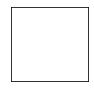

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(30) #input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        x = self.fc1(x)
        return F.log_softmax(x, dim = 2)

model = Net()
model.to(device)
print(model)

Net(
  (conv1): Conv1d(1, 128, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (avgPool): AvgPool1d(kernel_size=(30,), stride=(30,), 

In [19]:
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

In [35]:
log_interval=20

def train(model, epoch):
    model.train()
    train_loss=[]
    train_acc=[]
    correct=0.
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        data = data.requires_grad_() #set requires_grad to True for training
        output = model(data)
        output = output.permute(1, 0, 2) #original output dimensions are batchSizex1x10 
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
        loss = F.nll_loss(output[0], target) #the loss functions expects a batchSizex10 input
        loss.backward()
        optimizer.step()


        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))
        train_loss.append(loss)

        train_acc.append(100. * batch_idx / len(train_loader))



In [36]:
def test(model):

    model.eval()
    correct = 0
    test_acc=[]
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

def val_test(model):

    model.eval()
    correct = 0
    val_acc=[]
    val_loss=[]

    for batch_idx, (data, target) in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        loss = F.nll_loss(output[0], target) #the loss functions expects a batchSizex10 input
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()

        print('Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(val_loader.dataset),
                100. * batch_idx / len(val_loader), loss))
    val_loss.append(loss)
    val_acc.append(100. * correct / len(val_loader.dataset))

In [38]:
log_interval = 20
for epoch in range(1,2):
    if epoch == 31:
        print("First round of training complete. Setting learn rate to 0.001.")
        scheduler.step()
    train(model, epoch)
#    val_test(model)
    test(model)

Train Epoch: 1 [0/7079 (0%)]	Loss: 1.508612
Train Epoch: 1 [2560/7079 (36%)]	Loss: 1.474346
Train Epoch: 1 [5120/7079 (71%)]	Loss: 1.459259

Test set: Accuracy: 364/837 (43%)



In [39]:
#test_loader.dataset.classes
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 33.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 93.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 32.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 96.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 83.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])


In [40]:
## plot confusion matrix
#get per class accuracy
print(confusion_matrix.diag()/confusion_matrix.sum(1))


tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [51]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, **kwargs)
import numpy as np
class_names = test_loader.dataset.folders.copy
print(class_names)

def imshow(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)

<built-in method copy of list object at 0x7f52eedcd1e0>


In [52]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, **kwargs)

def visualize_results(model):   
    model.eval()    
    fig = plt.figure(figsize=(15, 32))
    inputs, targets = data
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)

    for j in range(50):
        ax = plt.subplot(10, 5, j+1)
        ax.axis('off')       
        ax.set_title('predicted: {} \n actual: {}'.format(class_names[preds[j]], class_names[targets[j]]))
        imshow(inputs.cpu().data[j])


visualize_results(model)

NameError: ignored

<Figure size 1080x2304 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
plt.figure(dpi=100)
plt.plot(train_loss, label='training loss')
#plt.plot(test_loss, label='testing loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.grid(True)

NameError: ignored

<Figure size 600x400 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt
plt.figure(dpi=100)
plt.plot(train_acc, label='training Accuracy')
#plt.plot(test_loss, label='testing loss')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.grid(True)

NameError: ignored

<Figure size 600x400 with 0 Axes>